In [1]:
import os
import warnings
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

In [3]:
class suppress_stdout_stderr(object):
    """
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    """

    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

##### Daily website

In [4]:
data = pd.read_csv('data/daily-website-visitors.csv')

In [5]:
data.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [6]:
data = data[['Date', 'Page.Loads']]
data['ds'] = pd.to_datetime(data['Date'])
data = data.drop('Date', axis=1)
data = data.rename(columns={'Page.Loads': 'y'})
data['y'] = data['y'].str.replace(',', '').astype(float)
data = data[['ds', 'y']]

##### EDA

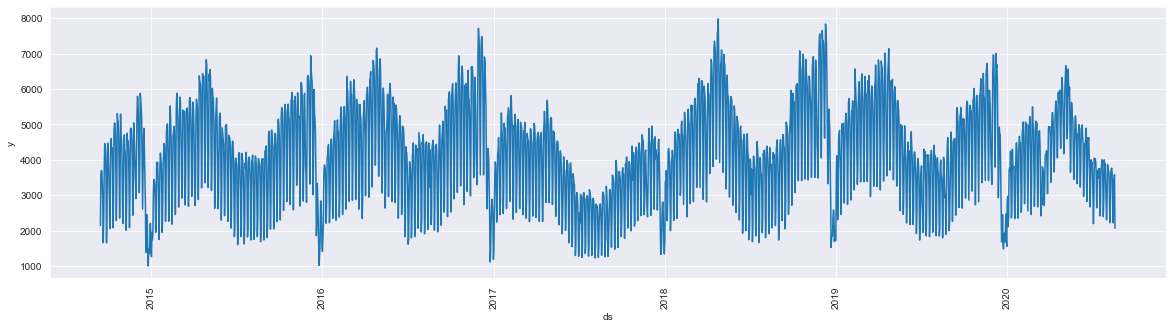

In [7]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=data, x='ds', y='y')
plt.xticks(rotation=90)
plt.show()

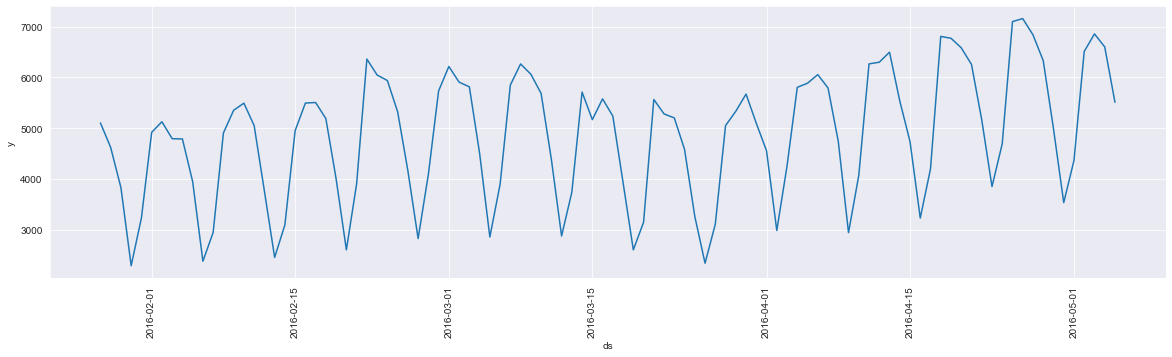

In [8]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=data.iloc[500:600], x='ds', y='y')
plt.xticks(rotation=90)
plt.show()

In [9]:
ts = pd.date_range(start=data.ds.min(), end=data.ds.max(), freq='D')

len(ts) == len(data)

True

In [10]:
train_series = data[data.ds < (data.ds.max() - timedelta(days=30))].copy()
test_series = data[data.ds >= (data.ds.max() - timedelta(days=30))].copy()

### Models

In [11]:
def draw_predictions(data: pd.DataFrame) -> None:
    series = data.set_index('ds').unstack().reset_index(drop=False)
    series.columns = ['type', 'ds', 'value']
    
    plt.figure(figsize=(20, 5))
    sns.lineplot(data=series, x='ds', y='value', hue='type')
    plt.xticks(rotation=90)
    plt.show()

#### Vanilla Prophet

In [12]:
import prophet

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

In [13]:
prophet.diagnostics.logging.disable(level=50)

In [14]:
fb = prophet.Prophet()

with suppress_stdout_stderr():
    fb.fit(train_series)

In [15]:
predictions = fb.make_future_dataframe(periods=len(test_series), freq='D')
forecast = fb.predict(predictions)

In [16]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-09-14,3346.896218,1456.222669,2675.246295,3346.896218,3346.896218,-1281.439359,-1281.439359,-1281.439359,-872.562408,-872.562408,-872.562408,-408.876951,-408.876951,-408.876951,0.0,0.0,0.0,2065.456858
1,2014-09-15,3349.975887,3049.568398,4322.229627,3349.975887,3349.975887,373.841502,373.841502,373.841502,734.255770,734.255770,734.255770,-360.414268,-360.414268,-360.414268,0.0,0.0,0.0,3723.817389
2,2014-09-16,3353.055556,3268.150745,4501.818173,3353.055556,3353.055556,532.932678,532.932678,532.932678,845.435740,845.435740,845.435740,-312.503062,-312.503062,-312.503062,0.0,0.0,0.0,3885.988234
3,2014-09-17,3356.135225,3275.858735,4484.962095,3356.135225,3356.135225,521.476722,521.476722,521.476722,787.165943,787.165943,787.165943,-265.689221,-265.689221,-265.689221,0.0,0.0,0.0,3877.611947
4,2014-09-18,3359.214894,3130.383645,4253.367144,3359.214894,3359.214894,314.284171,314.284171,314.284171,534.767594,534.767594,534.767594,-220.483423,-220.483423,-220.483423,0.0,0.0,0.0,3673.499065


In [17]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [18]:
v_fb_df = test_series.copy()
v_fb_df = v_fb_df.merge(forecast[['ds', 'yhat']], on='ds', how='left')

In [19]:
v_fb_df.head()

,ds,y,yhat
0,2020-07-20,3749.0,3992.109185
1,2020-07-21,3786.0,4100.229988
2,2020-07-22,4002.0,4036.767154
3,2020-07-23,3823.0,3777.286485
4,2020-07-24,3430.0,2831.207173


In [20]:
np.sqrt(mean_squared_error(v_fb_df['y'], v_fb_df['yhat']))

512.2325266529127

In [21]:
mean_absolute_percentage_error(v_fb_df['y'], v_fb_df['yhat'])

0.1360530885720578

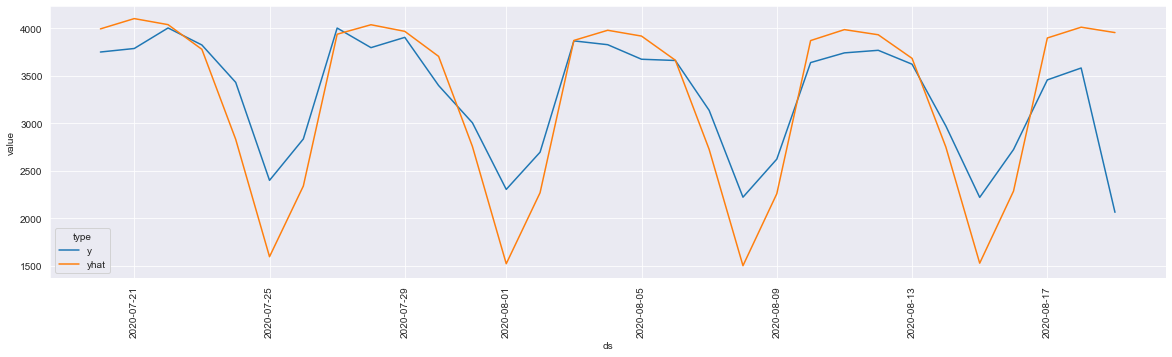

In [22]:
draw_predictions(v_fb_df)

#### Prophet + LGBM (+ Optuna)

In [23]:
import optuna
import optuna.integration.lightgbm as lgb
from optuna.integration.lightgbm import Dataset
import pandas as pd
import numpy as np

optuna.logging.set_verbosity(optuna.logging.ERROR)


class OptunaLGBMRegressor:
    """
    A wrapper class for the LightGBM Regressor with Optuna for hyperparameters tuning
    """

    def __init__(
        self,
        n_estimators: int,
        learning_rate: float = 0.01,
        metric: str = 'rmse',
        cat_columns: str = 'auto',
        seed: int = 42
    ):
        """
        Initializes a new instance of the OptunaLGBMRegressor class
        """
        self.params = {
            "n_estimators": n_estimators,
            "objective": "regression",
            "verbosity": -1,
            "metric": metric,
            "learning_rate": learning_rate,
            "boosting_type": 'gbdt',
            "random_state": seed
        }
        self.cat_columns = cat_columns
        self.model = None
        self.features = None
        self.is_fitted_ = False

    def _to_datasets(
        self, x_train: pd.DataFrame, y_train: np.ndarray, x_val: pd.DataFrame, y_val: np.ndarray
    ) -> (Dataset, Dataset):
        """
        Converts Pandas DataFrames to LightGBM Datasets
        """
        self.features = list(x_train.columns)
        X_val = x_val[self.features].copy()
        dtrain = Dataset(x_train, label=y_train, categorical_feature=self.cat_columns)
        dval = Dataset(X_val, label=y_val, categorical_feature=self.cat_columns)

        return dtrain, dval     

    def fit(self, X_train: pd.DataFrame, y_train: np.ndarray, X_val: pd.DataFrame, y_val: np.ndarray) -> None:
        dtrain, dval = self._to_datasets(X_train, y_train, X_val, y_val)
        
        self.model = lgb.tuner.train(
            self.params,
            dtrain,
            valid_sets=[dtrain, dval],
            verbose_eval=0,
            early_stopping_rounds=150
        )
        
        self.is_fitted_ = True

    def predict(self, X_test: pd.DataFrame) -> np.ndarray:
        assert self.is_fitted_, 'Model is not fitted!'
        return self.model.predict(X_test[self.features], num_iteration=self.model.best_iteration)


In [24]:
gbt_data = train_series.merge(forecast, on='ds', how='left')
train_gbt, val_gbt = train_test_split(gbt_data, test_size=0.15, random_state=42)

In [25]:
lgbm = OptunaLGBMRegressor(n_estimators=300, learning_rate=0.03, metric='mape', seed=42)

lgbm.fit(
    train_gbt.drop(['ds', 'y'], 1), train_gbt.y.values,
    val_gbt.drop(['ds', 'y'], 1), val_gbt.y.values
)

bagging, val_score: 0.079287: 100%|#############| 10/10 [00:03<00:00,  2.73it/s]
feature_fraction_stage2, val_score: 0.079287: 100%|#| 6/6 [00:02<00:00,  2.87it/
regularization_factors, val_score: 0.079134: 100%|#| 20/20 [00:07<00:00,  2.63it
min_data_in_leaf, val_score: 0.076911: 100%|######| 5/5 [00:01<00:00,  2.97it/s]


In [26]:
test_gbt = test_series.merge(forecast, on='ds', how='left')

preds = lgbm.predict(test_gbt.drop(['ds', 'y'], 1))

In [27]:
forecast_df = test_gbt[['ds', 'y', 'yhat']].copy()
forecast_df['gbt_yhat'] = preds

In [28]:
np.sqrt(mean_squared_error(forecast_df['y'], forecast_df['gbt_yhat']))

460.5106131604612

In [29]:
mean_absolute_percentage_error(forecast_df['y'], forecast_df['gbt_yhat'])

0.1166154388297548

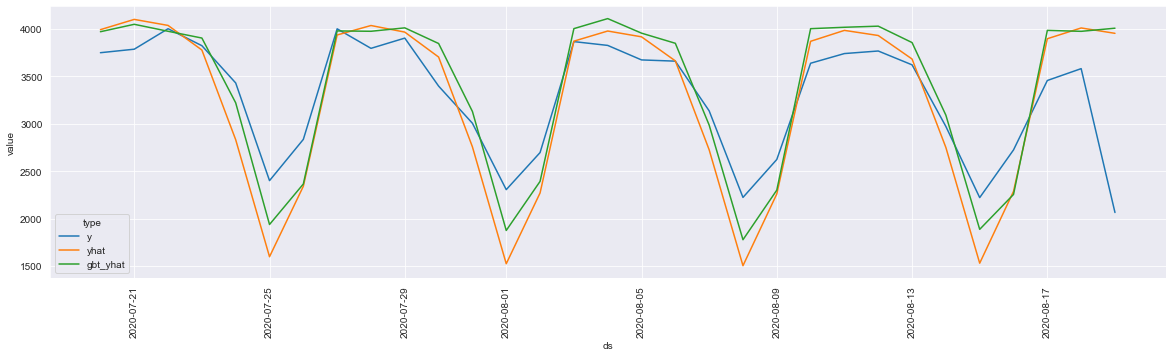

In [30]:
draw_predictions(forecast_df)

#### Prophets ensemble

In [31]:
import re
import pandas as pd
from typing import Optional
from itertools import product
from tqdm import tqdm
from holidays.holiday_base import HolidayBase
from prophet import Prophet


class ProphetsEnsemble:
    """An ensemble of Prophet models with different aggregation functions and frequencies."""

    def __init__(self, freq: str, levels: list, agg_fn: list, holidays_getter: HolidayBase = None):
        """Initializes an ensemble of Prophet models."""
        self.freq = freq
        self.levels = ['_'.join(x) for x in product(levels, agg_fn)]
        self.h_getter = holidays_getter
        self.prophets_ = dict()
        self.is_fitted_ = False
    
    @staticmethod
    def _resample(data: pd.DataFrame, freq: str, how: str) -> pd.DataFrame:
        """Resamples a time series DataFrame."""
        if how not in ['median', 'mean', 'sum']:
            raise NotImplementedError(f'Unknown function {how}. Only [median, mean, sum] are supported.') 
        return data.set_index('ds').resample(freq).agg(how).reset_index(drop=False)

    @staticmethod
    def _merge_key_gen(x, level: str) -> str:
        """Generates a key for merging DataFrames based on the frequency."""
        freq = re.sub('[\d]', '', level.split('_')[0])
        if freq == 'H':
            return f'{x.year}-{x.month}-{x.day}-{x.hour}'
        elif freq in ['D', 'M']:
            return f'{x.year}-{x.month}-{x.day}' if freq == 'D' else f'{x.year}-{x.month}'
        elif freq == 'W':
            return f'{x.isocalendar().year}-{x.isocalendar().week}'
        raise NotImplementedError(f'Only [H, D, W, M] are supported. {freq} was recieved as input!')
    
    def _get_holidays(self, data: pd.DataFrame) -> Optional[pd.DataFrame]:
        """Extracts holidays from the data."""
        if self.h_getter is None:
            return None
        holidays = data[['ds']].copy()
        holidays['holiday'] = holidays['ds'].apply(self.h_getter.get)
        return holidays.dropna()
    
    def _fit_level(self, data: pd.DataFrame, level: str) -> None:
        """Fits a Prophet model for a specific aggregation level."""
        resampled = self._resample(data, *level.split('_')) if level != self.freq else data.copy()
        fb = Prophet(holidays=self._get_holidays(resampled))
        with suppress_stdout_stderr():
            fb.fit(resampled)
        self.prophets_[level] = fb
        
    def _predict_level(self, periods: int, level: str) -> pd.DataFrame:
        """Makes predictions for a specific aggregation level."""
        fb = self.prophets_[level]
        df = fb.make_future_dataframe(periods=periods, freq=level.split('_')[0])
        forecasts = fb.predict(df)
        forecasts.columns = [f'{x}_{level}' for x in forecasts.columns]
        return forecasts
    
    def _combine_levels(self, base_df: pd.DataFrame, data: pd.DataFrame, level: str) -> pd.DataFrame:
        """Combines predictions from different aggregation levels."""
        key = lambda x: self._merge_key_gen(x, level)
        return (
            base_df.assign(key=base_df['ds'].apply(key))
            .merge(data.assign(key=data[f'ds_{level}'].apply(key)), on='key', how='left')
            .drop(['key', f'ds_{level}'], axis=1)
        )
    
    @staticmethod
    def _drop_redundant(data: pd.DataFrame) -> pd.DataFrame:
        """Drops redundant features from the DataFrame."""
        redundant = [col for col in data.columns if col != 'ds' and 'yhat' not in col and len(data[col].unique()) == 1]
        return data.drop(redundant, axis=1)
    
    def fit(self, data: pd.DataFrame) -> None:
        """Fits the Prophet models for all aggregation levels."""
        for level in tqdm([self.freq] + self.levels, 'Fitting prophets...'):
            self._fit_level(data, level)
        self.is_fitted_ = True
            
    def forecast(self, periods: int) -> pd.DataFrame:
        """Makes forecasts for all aggregation levels and combines them."""
        assert self.is_fitted_, 'Model is not fitted'
        forecasts = [self._predict_level(periods, level) for level in tqdm([self.freq] + self.levels, 'Forecasting...')]
        
        forecast = forecasts[0].rename(columns={f'ds_{self.freq}': 'ds', f'yhat_{self.freq}': 'yhat'})
        for level, fore in zip(self.levels, forecasts[1:]):
            forecast = self._combine_levels(forecast, fore, level)
            
        return self._drop_redundant(forecast)


In [32]:
pe = ProphetsEnsemble(freq='D', levels=['W', 'M'], agg_fn=['median'])

In [33]:
pe.fit(train_series)

Fitting prophets...: 100%|████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


In [34]:
pe_forecast = pe.forecast(len(test_series))

Forecasting...: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.64s/it]


In [35]:
gbt_data = train_series.merge(pe_forecast, on='ds', how='left')
train_gbt, val_gbt = train_test_split(gbt_data, test_size=0.15, random_state=42)

In [36]:
lgbm = OptunaLGBMRegressor(n_estimators=300, learning_rate=0.03, metric='mape', seed=42)

lgbm.fit(
    train_gbt.drop(['ds', 'y'], 1), train_gbt.y.values,
    val_gbt.drop(['ds', 'y'], 1), val_gbt.y.values
)

bagging, val_score: 0.062842: 100%|#############| 10/10 [00:05<00:00,  1.93it/s]
feature_fraction_stage2, val_score: 0.062842: 100%|#| 3/3 [00:01<00:00,  1.83it/
regularization_factors, val_score: 0.061667: 100%|#| 20/20 [00:11<00:00,  1.68it
min_data_in_leaf, val_score: 0.061667: 100%|######| 5/5 [00:02<00:00,  2.02it/s]


In [37]:
test_gbt = test_series.merge(pe_forecast, on='ds', how='left')
preds = lgbm.predict(test_gbt.drop(['ds', 'y'], 1))

In [38]:
forecast_df['pe_yhat'] = preds

In [39]:
np.sqrt(mean_squared_error(forecast_df['y'], forecast_df['pe_yhat']))

428.79392224523224

In [40]:
mean_absolute_percentage_error(forecast_df['y'], forecast_df['pe_yhat'])

0.10008674944935335

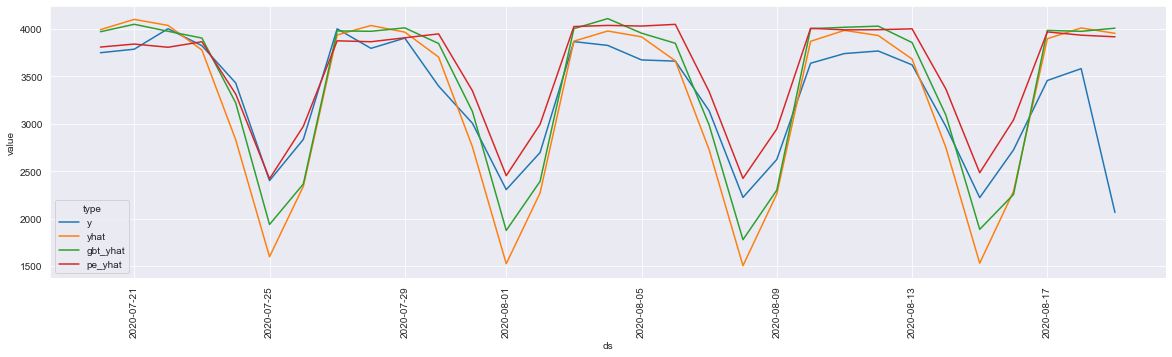

In [41]:
draw_predictions(forecast_df)